Initial setup and first topic model run

In [1]:
import wosis
import pandas as pd
import metaknowledge as mk
import json

C:\Users\douglasd\AppData\Local\Continuum\miniconda3\envs\biblio\lib\site-packages\fuzzywuzzy-0.17.0-py3.6.egg\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Analysis and search functions
from wosis.analysis import (preview_matches, search_records, keyword_matches, 
                            find_pubs_by_authors, preview_matches_by_keyword, get_unique_kw_titles,
                            remove_by_journals, remove_by_title)

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

In [3]:
# Read in data from temporary cache file
query_id = "756d39801152fe5f5f4ad3a3df9b6a30"
RC = mk.RecordCollection("tmp/{}.txt".format(query_id))

expected_num_records = 10694
num_records = len(RC)

#assert num_records == expected_num_records, \
#    "Mismatch in number of records - expected {}, got {}".format(expected_num_records, num_records)

print("Corpora consists of", num_records, "Publications")

Corpora consists of 15754 Publications


In [4]:
corpora_df = wosis.rec_to_df(RC)

corpora_df, removed_pubs = wosis.constrain.remove_empty_DOIs(corpora_df)
#maybe we don't want to do this for this analysis? older papers less likely to have dois?

Removing 1799 records with no DOIs


In [5]:
# removed_pubs

In [6]:
# Hiding keywords and abstract for tutorial (WoS-owned IP)
hide_columns = ['DE', 'abstract', 'keywords', 'DOI', 'id', 'kws']
corpora_df.loc[:, ~corpora_df.columns.isin(hide_columns)].head()  # display first 5

,year,title,AU,SO
0,2000,A global distribution of biodiversity inferred...,"Kleidon, A|Mooney, HA",GLOBAL CHANGE BIOLOGY
1,2012,On variational data assimilation for estimatin...,"Vira, J.|Sofiev, M.",ATMOSPHERIC ENVIRONMENT
2,2017,Stress-constrained continuum topology optimiza...,"Amir, Oded",STRUCTURAL AND MULTIDISCIPLINARY OPTIMIZATION
3,2008,Sensitivity study of large-scale particle imag...,"Hauet, Alexandre|Creutin, Jean-Dominique|Belle...",JOURNAL OF HYDROLOGY
4,2007,Fodder production and soil health with conjunc...,"Yadav, R. K.|Singh, S. P.|Lal, D.|Kumar, A.",LAND DEGRADATION & DEVELOPMENT


In [7]:
# Create a new metaknowledge collection
filtered_corpora = wosis.extract_recs(corpora_df.loc[:, 'id'], RC, name='Filtered Corpora')

In [8]:
from wosis.analysis import find_topics, get_topic_by_id

filtered_corpora_df = wosis.rec_to_df(filtered_corpora)
topic_model, trans, feature_names = find_topics(filtered_corpora_df, num_topics=5)

Topic 1: model water soil flow parameters sensitivity river data groundwater analysis
Topic 2: optimization design method shape topology sensitivity problem element finite analysis
Topic 3: energy cycle environmental life emissions production assessment waste impact lca
Topic 4: uncertainty model models stochastic data analysis method quantification parameter carlo
Topic 5: risk exposure assessment health cancer risks human flood probabilistic analysis


In [9]:
topic_pubs = {
    'model': get_topic_by_id(topic_model, trans, 4, filtered_corpora_df),
    # 'UA': get_topic_by_id(topic_model, trans, 8, filtered_corpora_df),
    # 'SA': get_topic_by_id(topic_model, trans, 20, filtered_corpora_df),    
}

# len(topic_pubs['model']), len(topic_pubs['UA'])
len(topic_pubs['model'])

3203

In [10]:
# find paper of interest - see if it's still in the corpora
for i in range(1,5):
    topic_set = get_topic_by_id(topic_model, trans, i, filtered_corpora_df)
    
    topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')
    tmp_df = pd.DataFrame(topic_recs.forNLP(extraColumns=['DOI']))

    if len(tmp_df.loc[tmp_df["DOI"] == '10.1016/j.jocs.2015.08.008', :]) > 0:
        print("Found paper in topic", i)
        break

Found paper in topic 4


In [11]:
topic_set.loc[:, ~topic_set.columns.isin(hide_columns)].head(10)

,year,title,AU,SO
6,2007,Uncertainties analysis for the plutonium dosim...,"Bess, John D.|Krahenbuhl, Melinda P.|Miller, S...",HEALTH PHYSICS
7,2008,Robust data assimilation in hydrological model...,"Wang, Dingbao|Cai, Ximing",ADVANCES IN WATER RESOURCES
10,2013,Generalized Likelihood Uncertainty Estimation ...,"Li, Zhijie|Chen, Qiuwen|Xu, Qiang|Blanckaert, ...",MATHEMATICAL PROBLEMS IN ENGINEERING
12,2005,Accounting for both random errors and systemat...,"Vasquez, VR|Whiting, WB",RISK ANALYSIS
20,2015,Impact of space-time mesh adaptation on solute...,"Esfandiar, Bahman|Porta, Giovanni|Perotto, Sim...",WATER RESOURCES RESEARCH
25,2014,Towards predictive data-driven simulations of ...,"Rochoux, M. C.|Ricci, S.|Lucor, D.|Cuenot, B.|...",NATURAL HAZARDS AND EARTH SYSTEM SCIENCES
27,2007,The Data Uncertainty Engine (DUE): A software ...,"Brown, James D.|Heuvelink, Gerard B. M.",COMPUTERS & GEOSCIENCES
28,2010,Identification and classification of uncertain...,"Warmink, J. J.|Janssen, J. A. E. B.|Booij, M. ...",ENVIRONMENTAL MODELLING & SOFTWARE
30,2014,INFERENCE AND UNCERTAINTY PROPAGATION OF ATOMI...,"Salloum, Maher|Templeton, Jeremy",INTERNATIONAL JOURNAL FOR UNCERTAINTY QUANTIFI...
32,2003,Bayesian uncertainty assessment in multicompar...,"Bates, SC|Cullen, A|Raftery, AE",ENVIRONMETRICS


In [12]:
topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')

In [13]:
#run topic model on topic 4
topic_4_recs_df = wosis.rec_to_df(topic_recs)
topic_model, trans, feature_names = find_topics(topic_4_recs_df, num_topics=5)

Topic 1: uncertainty model uncertainties analysis water data quality models assessment modeling
Topic 2: stochastic polynomial chaos random quantification equations method expansion collocation solution
Topic 3: sensitivity analysis model models global parameters indices input based output
Topic 4: bayesian model data parameter models calibration inference posterior prior estimation
Topic 5: carlo monte sampling method probability simulation failure distribution reliability function


<hr>

Plotting subtopic trends over time <br>
Two topics are chosen, papers focusing on applications of SA and papers focusing on theoretical development of SA <br>
The next task is to plot the category trends over time.

In [14]:
subtopic1 = wosis.get_topic_by_id(topic_model, trans, 1, topic_4_recs_df)
subtopic3 = wosis.get_topic_by_id(topic_model, trans, 3, topic_4_recs_df)

In [15]:
model_recs = wosis.extract_recs(subtopic1['id'], RC)
app_papers = ({
    'app_papers': model_recs
},
{
    'app_papers': len(subtopic1)
})

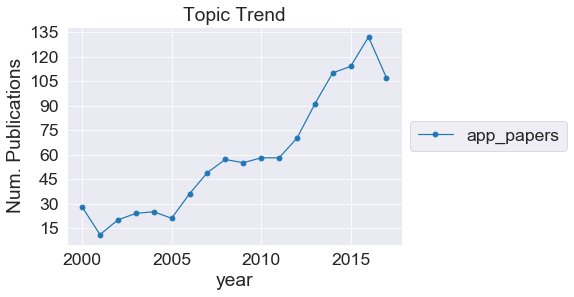

In [18]:
wos_plot.plot_topic_trend([app_papers,], total_rc=None, title='Topic Trend')

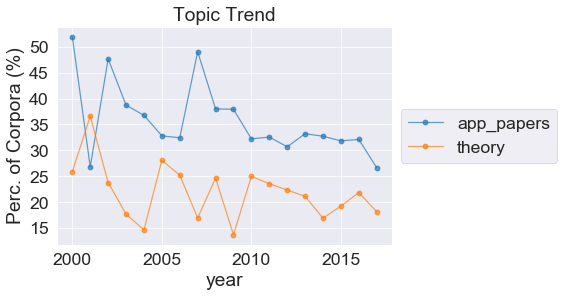

In [19]:
model_recs = wosis.extract_recs(subtopic3['id'], RC)

theory = ({
    'theory': model_recs
},
{
    'theory': len(model_recs)
})

wos_plot.plot_topic_trend([app_papers, theory], total_rc=topic_recs, title='Topic Trend')

In [20]:
app_papers[1], theory[1]

({'app_papers': 1066}, {'theory': 665})

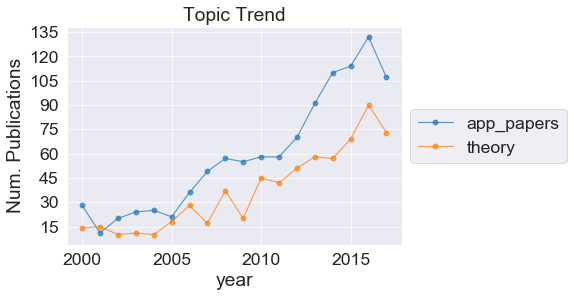

In [21]:
wos_plot.plot_topic_trend([app_papers, theory], total_rc=None, title='Topic Trend')

<hr>

Here the results to app_paper are sorted with reference to the packages they support.

In [45]:
#keyword criteria match on app_papers
#want to see trend of keywords over time
#add languages
topic_4_1_recs = wosis.extract_recs(topic_set.loc[:, 'id'], topic_4_recs, 'Topic of Interest')

criteria = {
    'GLUE': set(['GLUE', 'generalized likelihood uncertainty estimation', 'distributed models', 'calibration uncertainty', 'likelihood', 'uncertainty estimation', 'epistemic error', 'rainfall-runoff models', 'equifinality', 'Plynlimon']),
    'PEST': set(['PEST', 'parameter estimation', 'model-independent parameter estimation & uncertainty analysis', 'user interfaces', 'computer systems', 'data processing', 'least squares', 'spatial systems', 'mathematical models', 'software']),
    'SALib': set(['salib', 'sensitivity analysis', 'python', 'uncertainty', 'variance-based', 'global sensitivity analysis', 'fractional factorial', 'method of morris']),
    'MADS': set(['sensitivity analysis', 'MADS', 'julia', 'julialang', 'parameter estimation', 'model inversion & calibration', 'uncertainty quantification', 'model selection', 'model averaging', 'model reduction', 'surrogate modeling', 'machine learning', 'blind source separation', 'decision analysis & support']),
    'PSUADE': set(['uncertainty quantification', 'sensitivity analysis', 'parameter estimation', 'space-filling sample', 'PSUADE', 'Problem Solving environment for Uncertainty Analysis and Design Exploration']),
    'SAFE': set(['global sensitivity analysis', 'matlab', 'octave', 'open-source software', 'safe', 'sensitivity analysis for everyone']),
    'VARS-TOOL': set(['VARS-TOOL', 'VARS', 'global sensitivity analysis', 'uncertainty analysis', 'variogram analysis of response surfaces', 'variogram', 'sobol', 'morris', 'progressive latin hypercube sampling', 'plhs', 'dynamical systems models', 'sensitivty indices', 'performance metrics']),
    'UQLab': set(['uncertainty quantification', 'uncertainty analysis', 'sensitivity analysis', 'computer systems', 'uqlab']),
    'DAKOTA': set(['dakota', 'mathematical methods', 'computing', 'computer-aided design', 'finite element method', 'nonlinear programming', 'sensitivity analysis', 'parallel processing', 'stochastic processes', 'integer processing', 'iterative methods', 'computer programs']),
    'HDMR': set(['global sensitivity analysis', 'hdmr', 'high dimensional model representation', 'matlab', 'matlab software', 'graphic user interface', 'gui']),
    'SimLab': set(['sensitivity analysis', 'uncertainty analysis', 'model development', 'global sensitivity analysis', 'simlab'])
}

crit_matches, crit_summary = wosis.keyword_matches_by_criteria(topic_4_1_recs, criteria, threshold=95.0)

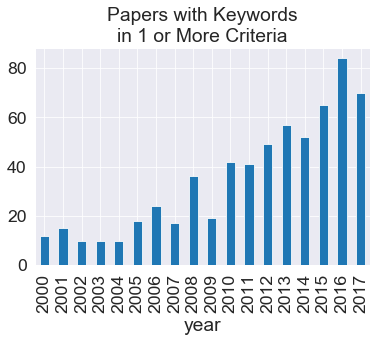

In [52]:
criteria1_df = wosis.collate_keyword_criteria_matches(topic_4_1_recs, crit_matches)
wos_plot.plot_criteria_trend(criteria1_df, threshold=1)

<hr>

The following includes more analysis of the papers from topic 4 and topic 4.3. <br>
- Publication trends
- Criteria matching and trends of criteria.

In [22]:
# find paper of interest - see if it's still in the corpora
#for i in range(1,5):
    topic_set = get_topic_by_id(topic_model, trans, 3, topic_4_recs_df)
    
    topic_4_recs = wosis.extract_recs(topic_set.loc[:, 'id'], topic_recs, 'Topic of Interest')
    tmp_df = pd.DataFrame(topic_recs.forNLP(extraColumns=['DOI']))

#    if len(tmp_df.loc[tmp_df["DOI"] == '10.1016/j.jocs.2015.08.008', :]) > 0:
#        print("Found paper in topic", i)
#        break

In [23]:
topic_set.loc[:, ~topic_set.columns.isin(hide_columns)].head(10)

,year,title,AU,SO
0,2016,Application of Adjoint Sensitivity Analysis to...,"Jakubczak, Michal|Fujarewicz, Krzysztof|Pietka...",INFORMATION TECHNOLOGIES IN MEDICINE (ITIB 201...
1,2016,Measuring efficiency of university-industry Ph...,"Salimi, Negin|Rezaei, Jafar",SCIENTOMETRICS
11,2014,Analytical HDMR formulas for functions express...,"Li, Genyuan|Rabitz, Herschel",JOURNAL OF MATHEMATICAL CHEMISTRY
44,2016,Investigation of uncertainty in CO2 reservoir ...,"Yoshida, Nozomu|Levine, Jonathan S.|Stauffer, ...",INTERNATIONAL JOURNAL OF GREENHOUSE GAS CONTROL
46,2015,Polynomial chaos expansions for uncertainty pr...,"Rajabi, Mohammad Mahdi|Ataie-Ashtiani, Behzad|...",JOURNAL OF HYDROLOGY
56,2008,Postmodeling sensitivity analysis to detect th...,"Jamshidian, Mortaza|Mata, Matthew",MULTIVARIATE BEHAVIORAL RESEARCH
57,2017,Gaussian process emulation of an individual-ba...,"Oyebamiji, O. K.|Wilkinson, D. J.|Jayathilake,...",JOURNAL OF COMPUTATIONAL SCIENCE
59,2011,Global sensitivity analysis of large-scale num...,"Rohmer, Jeremy|Foerster, Evelyne",COMPUTERS & GEOSCIENCES
60,2012,Change of Support in Spatial Variance-Based Se...,"Saint-Geours, Nathalie|Lavergne, Christian|Bai...",MATHEMATICAL GEOSCIENCES
67,2016,Visually Exploring Differences of DTI Fiber Mo...,"Mei, Honghui|Chen, Haidong|Guo, Fangzhou|Zhang...",E-LEARNING AND GAMES


In [24]:
#find a paper by DOI
#ua_topic_df = pd.DataFrame(topic_recs.forNLP(extraColumns=["DOI"]))

#ua_topic_df.loc[ua_topic_df["DOI"] == '10.1016/j.jocs.2015.08.008', :]

In [25]:
#rec = RC.getID('WOS:000367774700005')
#rec

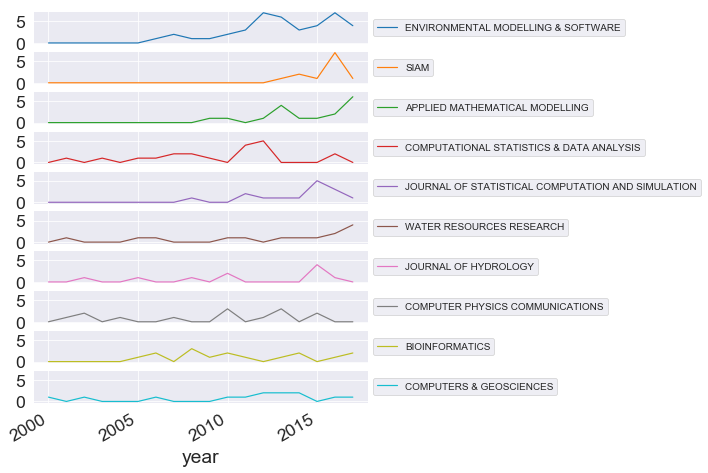

In [26]:
#publication trend for top 10 journals
wos_plot.plot_journal_pub_trend(topic_4_recs)

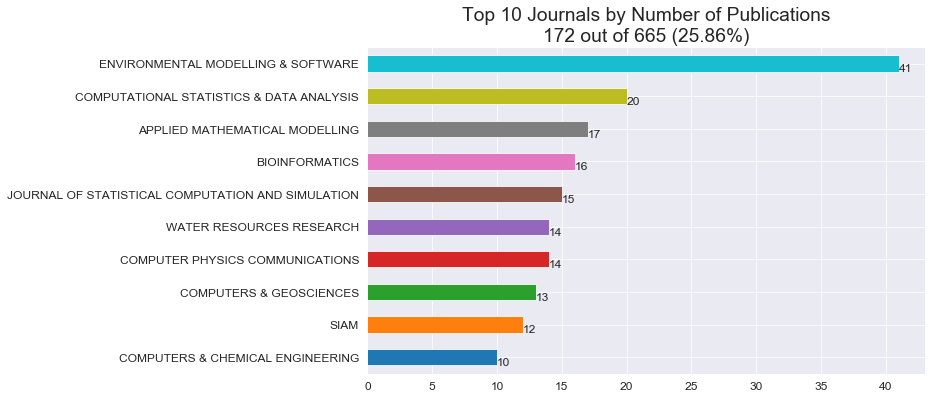

In [27]:
#Top 10 jorunals by number of publications
wos_plot.plot_pubs_per_journal(topic_4_recs, top_n=10, annotate=True, show_stats=True)

In [28]:
#top papers by citation
wosis.analysis.pub_citations(topic_4_recs)[0:50]
#ideas: could take first 1000 by citation number, but higher citations would favour older papers.  Taking by year?
#or simply choose first 1000 matches?

,Citations
Publication,
"Saltelli, A, 1999, A quantitative model-independent method for global sensitivity analysis of model output, TECHNOMETRICS, 41, 39, 6699137",328
"Saltelli, A., 2008, Global Sensitivity Analysis, The Primer, 287698885",183
"Sobol, I. M., 1993, Sensitivity analysis for nonlinear mathematical models, Math. Model. Comput. Exp., 1, 407, 2602363",160
"Sobol, IM, 1998, On quasi-Monte Carlo integrations, MATHEMATICS AND COMPUTERS IN SIMULATION, 47, 103, 7895728",111
"Saltelli, Andrea, 2010, Variance based sensitivity analysis of model output. Design and estimator for the total sensitivity index, COMPUTER PHYSICS COMMUNICATIONS, 181, 259, 287085385",99
"IMAN, RL, 1990, A ROBUST MEASURE OF UNCERTAINTY IMPORTANCE FOR USE IN FAULT TREE SYSTEM-ANALYSIS, RISK ANALYSIS, 10, 401, 8122917",93
"MORRIS, MD, 1991, FACTORIAL SAMPLING PLANS FOR PRELIMINARY COMPUTATIONAL EXPERIMENTS, TECHNOMETRICS, 33, 161, 6699066",89
"Helton, JC, 1999, Performance assessment for radioactive waste disposal, RISK ANALYSIS, 19, 759, 41431164",84
"Borgonovo, E., 2012, Model emulation and moment-independent sensitivity analysis: An application to environmental modelling, ENVIRONMENTAL MODELLING & SOFTWARE, 34, 105, 431033534",72


In [29]:
#first 10 papers in chosen topic
topic_df = wosis.link_to_pub(topic_4_recs)  # Creates a new column called 'DOI link'
topic_df.loc[:, ~topic_df.columns.isin(hide_columns)].head(10)

,year,title,AU,SO,DOI link
0,2010,Assessment of the sensitivity and prediction u...,"Elsawwaf, M.|Willems, P.|Feyen, J.",JOURNAL OF HYDROLOGY,https://dx.doi.org/10.1016/j.jhydrol.2010.10.002
1,2016,Application of Adjoint Sensitivity Analysis to...,"Jakubczak, Michal|Fujarewicz, Krzysztof|Pietka...",INFORMATION TECHNOLOGIES IN MEDICINE (ITIB 201...,https://dx.doi.org/10.1007/978-3-319-39904-1_11
2,2016,Measuring efficiency of university-industry Ph...,"Salimi, Negin|Rezaei, Jafar",SCIENTOMETRICS,https://dx.doi.org/10.1007/s11192-016-2121-0
3,2013,MEASURING SENSITIVITY OF PROCUREMENT DECISIONS...,"Marzouk, Mohamed|El Shinnawy, Noha|Moselhi, Os...",INTERNATIONAL JOURNAL OF INFORMATION TECHNOLOG...,https://dx.doi.org/10.1142/S0219622013500168
4,2009,Global Sensitivity Analysis Techniques for Pro...,"Mishra, Srikanta|Deeds, Neil|Ruskauff, Greg",GROUND WATER,https://dx.doi.org/10.1111/j.1745-6584.2009.00...
5,2016,Estimation of the Derivative-Based Global Sens...,"De Lozzo, Matthias|Marrel, Amandine",SIAM-ASA JOURNAL ON UNCERTAINTY QUANTIFICATION,https://dx.doi.org/10.1137/15M1013377
6,2014,Analytical HDMR formulas for functions express...,"Li, Genyuan|Rabitz, Herschel",JOURNAL OF MATHEMATICAL CHEMISTRY,https://dx.doi.org/10.1007/s10910-014-0365-6
7,2011,Interval analysis on non-linear monotonic syst...,"Destercke, Sebastien|Guillard, Valerie",COMPUTERS AND ELECTRONICS IN AGRICULTURE,https://dx.doi.org/10.1016/j.compag.2011.08.014
8,2015,Variance-based global sensitivity analysis for...,"Dai, Heng|Ye, Ming",JOURNAL OF HYDROLOGY,https://dx.doi.org/10.1016/j.jhydrol.2015.06.034
9,2007,New approach for microkinetic mean-field model...,"Sjoblom, Jonas|Creaser, Derek",COMPUTERS & CHEMICAL ENGINEERING,https://dx.doi.org/10.1016/j.compchemeng.2006....


In [30]:
topic_4_3_recs = wosis.extract_recs(topic_set.loc[:, 'id'], topic_4_recs, 'Topic of Interest')
tmp_df = pd.DataFrame(topic_4_recs.forNLP(extraColumns=['DOI']))

In [34]:
topic_4_3 = wosis.link_to_pub(topic_4_3_recs)
topic_4_3.to_csv('topic_4_3.csv')

In [35]:
#want to see trend of global SA over years
#also should make a table of papers, see below
criteria = {
    'LSA': set(['local sensitivity analysis', 'LSA', 'local sensitivity']),
    'GSA': set(['global sensitivity analysis', 'GSA', 'global sensitivity']),
    'OAT': set(['one-at-a-time', 'OAT'])
}

crit_matches, crit_summary = wosis.keyword_matches_by_criteria(topic_4_3_recs, criteria, threshold=95.0)

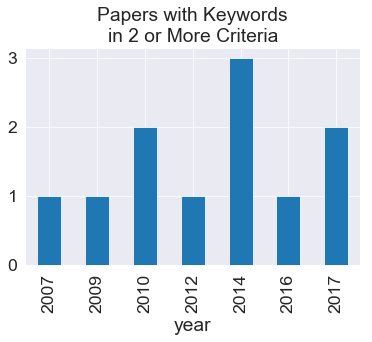

In [36]:
criteria_df = wosis.collate_keyword_criteria_matches(topic_4_3_recs, crit_matches)
wos_plot.plot_criteria_trend(criteria_df, threshold=2)

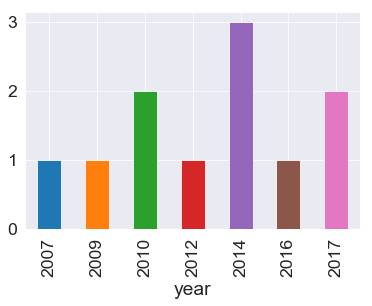

In [37]:
#want to view the papers in the above plot
crit_trend_tmp = criteria_df.loc[criteria_df['num_criteria_match'] > 1, ~criteria_df.columns.isin(hide_columns)]

crit_trend_tmp.groupby('year').count()['title'].plot(kind='bar')

In [38]:
lsa_matches = wosis.keyword_matches(topic_4_3_recs, ['local sensitivity', 'LSA', 'local sensitivity analysis'], threshold=95.0)

In [39]:
gsa_matches = wosis.keyword_matches(topic_4_3_recs, ['global sensitivity', 'GSA', 'global sensitivity analysis'], threshold=95.0)

In [40]:
oat_matches = wosis.keyword_matches(topic_4_3_recs, ['one-at-a-time', 'OAT'], threshold=95.0)

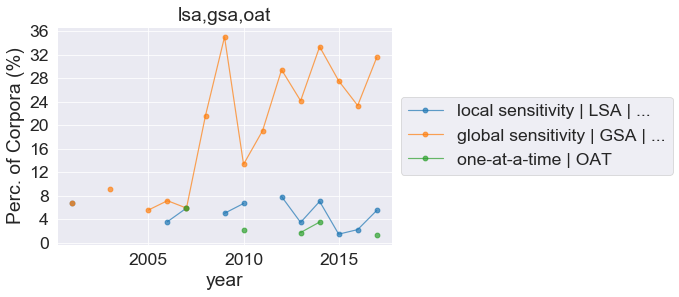

In [41]:
wos_plot.plot_topic_trend([lsa_matches, gsa_matches, oat_matches], topic_4_3_recs, 'lsa,gsa,oat')

<hr>

Network analysis, cocite and coauthor networks
<br> Further formatting/data extraction required, see networkx documentation

In [31]:
#import network packages
import metaknowledge as mk
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
#co-author network
coAuths = topic_recs.networkCoAuthor()
print(mk.graphStats(coAuths))

Nodes: 8721
Edges: 21454
Isolates: 148
Self loops: 2
Density: 0.000564229
Transitivity: 0.841433


C:\Users\douglasd\AppData\Local\Continuum\miniconda3\envs\biblio\lib\site-packages\networkx-2.2-py3.6.egg\networkx\drawing\layout.py:595: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((delta**2).sum(axis=0))
C:\Users\douglasd\AppData\Local\Continuum\miniconda3\envs\biblio\lib\site-packages\networkx-2.2-py3.6.egg\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


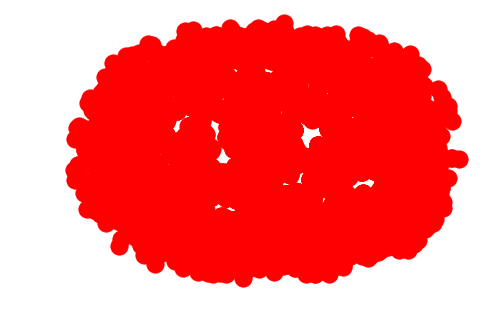

In [54]:
nx.draw_spring(coAuths, with_labels = False)

In [55]:
#highly cited co-atuhor network, how do I limit nodes? Needs to use topic 1 only, not full data base
minWeight = 3
maxWeight = 10
proccessedcoAuths = coAuths.copy()
mk.dropEdges(proccessedcoAuths, minWeight, maxWeight, dropSelfLoops = True)
mk.graphStats(proccessedcoAuths)

'Nodes: 8721\nEdges: 271\nIsolates: 8427\nSelf loops: 0\nDensity: 7.12716E-06\nTransitivity: 0.754757'

In [56]:
mk.dropNodesByDegree(proccessedcoAuths, 1)
mk.graphStats(proccessedcoAuths)

'Nodes: 294\nEdges: 271\nIsolates: 0\nSelf loops: 0\nDensity: 0.00629194\nTransitivity: 0.754757'

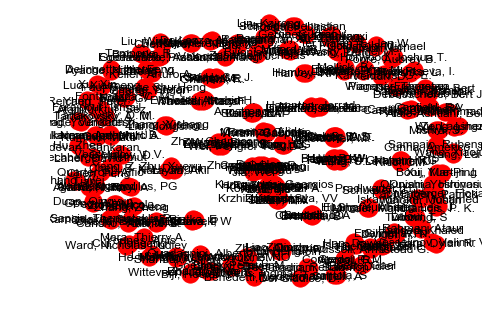

In [57]:
nx.draw_spring(proccessedcoAuths, with_labels = True)

In [32]:
minWeight = 30
maxWeight = 35
coCites = topic_4_3_recs.networkCoCitation()
mk.dropEdges(coCites, minWeight, maxWeight, dropSelfLoops = True)
mk.dropNodesByDegree(coCites, 5)
print(mk.graphStats(coCites))

Nodes: 49
Edges: 51
Isolates: 0
Self loops: 0
Density: 0.0433673
Transitivity: 0.0372671


C:\Users\douglasd\AppData\Local\Continuum\miniconda3\envs\biblio\lib\site-packages\networkx-2.2-py3.6.egg\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


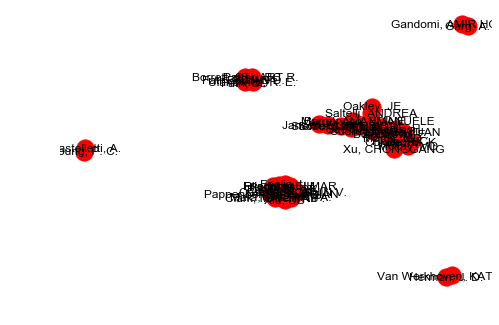

In [33]:
nx.draw_spring(coCites, with_labels = True)